In [1]:
%reload_ext autoreload
%autoreload 2

# imports
import os
import ast
import math
import json
import requests
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import ipywidgets as widgets

import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf


from scipy import stats
from datetime import datetime as dt
from ipywidgets import interact, interactive, fixed, interact_manual

from IPython.display import HTML
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
import helpers

# Data Loading , the imprt_movies_data function load and preprocess the data
movies,characters = helpers.import_movies_data("./data/")

movies.shape

/Users/zhouyanling/Downloads/CS-401/ada/ada-2023-project-zalix/helpers.py:73: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  movies["year_released"] = pd.to_datetime(


(14369, 13)

(784,)
 "/m/07s9rl0": "Drama"                    3486
 "/m/01z4y": "Comedy"                     1999
{"/m/01jfsb": "Thriller"                  1566
 "/m/01z4y": "Comedy"}                    1387
 "/m/01g6gs": "Black-and-white"}          1348
                                          ... 
{"/m/03jp5h0": "Archaeology"                 1
 "/m/0fx2s": "Tragedy"}                      1
{"/m/0hj3n11": "Environmental Science"       1
{"/m/01lrrt": "Melodrama"}                   1
{"/m/01lmb_": "Sword and Sandal"             1
Name: count, Length: 784, dtype: int64


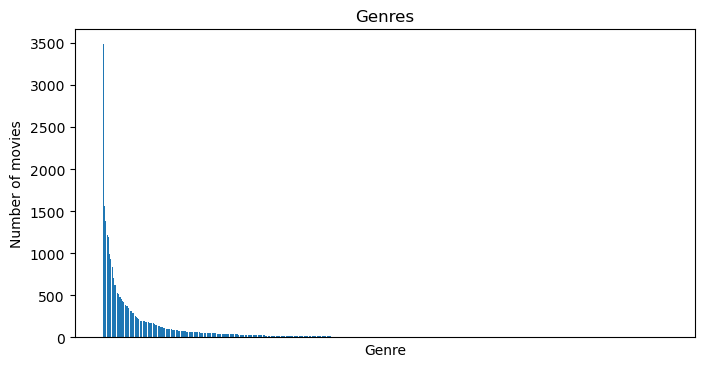

In [3]:
#genres
genres = movies["movie_genres"].str.split(",", expand=True).stack().value_counts()
print(genres.shape)
print(genres)
#plot genres
plt.figure(figsize=(8, 4))
plt.bar(genres.index, genres.values)
#hide x labels
plt.xticks([])
#plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()

In [4]:
#extract the main genre
def extract_genres(row):
    try:
        genres_dict = json.loads(row)
        return list(genres_dict.values()) if genres_dict else ['NaN']
    except json.JSONDecodeError:
        return ['NaN']

# Apply the function to create a new 'genre' column
movies['genre'] = movies['movie_genres'].apply(extract_genres)
genre=movies['genre'].explode().copy()
genre=genre[genre!='NaN']
genre=genre.value_counts()
#find the unique genres
unique_genres = genre.index
print(unique_genres)

Index(['Drama', 'Comedy', 'Black-and-white', 'Romance Film', 'Thriller',
       'Action', 'Crime Fiction', 'Short Film', 'Indie', 'Adventure',
       ...
       'Historical Documentaries', 'Race movie', 'Science fiction Western',
       'Kitchen sink realism', 'Filipino', 'Sci-Fi Thriller',
       'Political Documetary', 'Nuclear warfare', 'Space opera',
       'Revisionist Fairy Tale'],
      dtype='object', name='genre', length=323)


In [5]:
# give the top 10 genres that has the largerst number of movies and store them in genre_main
genre_main = genre[:10]
print(genre_main.shape)
print(genre_main.index)

(10,)
Index(['Drama', 'Comedy', 'Black-and-white', 'Romance Film', 'Thriller',
       'Action', 'Crime Fiction', 'Short Film', 'Indie', 'Adventure'],
      dtype='object', name='genre')


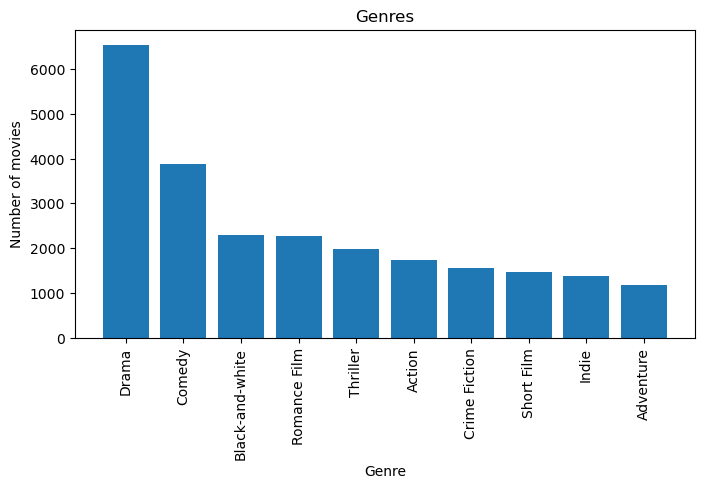

In [6]:
#plot the top 10 genres
plt.figure(figsize=(8, 4))
plt.bar(genre_main.index, genre_main.values)
plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()


In [7]:
#filter the movies that have the genres in genre_main, not necessarily the first genre
movies_main = movies[movies['genre'].apply(lambda x: any(item for item in x if item in genre_main.index))].copy()
print(movies_main.shape)
movies_main.head()


(12463, 14)


,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001,tt0228333,4.9,56928.0,"[Thriller, Science Fiction, Horror, Adventure,..."
2,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",1913,tt0002894,6.8,17.0,"[Short Film, Silent film, Indie, Black-and-whi..."
3,10408933,/m/02qc0j7,Alexander's Ragtime Band,1938-08-16,3600000.0,106.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/04t36"": ""Musical"", ""/m/01z4y"": ""Comedy"", ...",1938,tt0029852,6.8,2268.0,"[Musical, Comedy, Black-and-white]"
5,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,tt0097499,7.5,31208.0,"[Costume drama, War film, Epic, Period piece, ..."
6,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,tt0058331,7.8,181829.0,"[Children's/Family, Musical, Fantasy, Comedy, ..."


(10,)
Index(['Drama', 'Comedy', 'Black-and-white', 'Romance Film', 'Thriller',
       'Action', 'Crime Fiction', 'Short Film', 'Indie', 'Adventure'],
      dtype='object', name='genre')


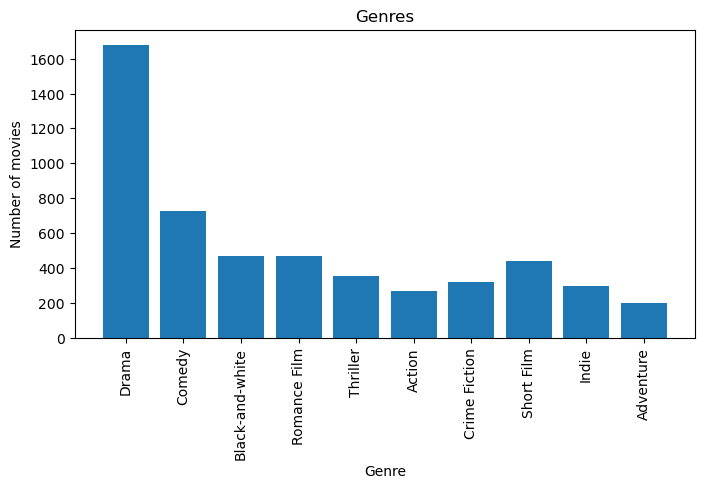

In [8]:
#filter the movies with rating higher than 7 from the movies_main dataset
movies_main_filtered= movies_main[movies_main['averageRating']>=7].copy()
#for each genre in genre_main, find the number of movies in movies_main_filter that have the genre
#and plot the number of movies for each genre
genre_main_filtered = movies_main_filtered['genre'].explode().value_counts()[genre_main.index]
print(genre_main_filtered.shape)
print(genre_main_filtered.index)
plt.figure(figsize=(8, 4))
plt.bar(genre_main_filtered.index, genre_main_filtered.values)
plt.xticks(rotation=90)
plt.title("Genres")
plt.xlabel("Genre")
plt.ylabel("Number of movies")
plt.show()

(10, 2)


/var/folders/xd/632j9v0549bf40k68lrscmkh0000gn/T/ipykernel_6577/1735292041.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  genre_ratio = pd.concat([genre_ratio, pd.DataFrame({'genre': [g], 'ratio': [ratio]})], ignore_index=True)#sort the dataframe by ratio


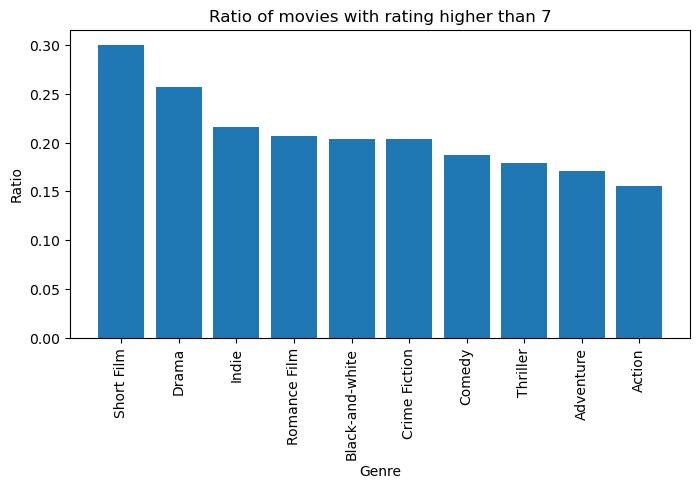

In [9]:
#for each genre, calculate the ratio of movies with rating higher than 7 / total number of movies in that genre
genre_ratio = pd.DataFrame(columns=['genre', 'ratio'])
for g in genre_main.index:
    ratio = len(movies_main_filtered[movies_main_filtered['genre'].apply(lambda x: g in x)]) / len(movies_main[movies_main['genre'].apply(lambda x: g in x)])
    #add the genre and ratio to the dataframe
    genre_ratio = pd.concat([genre_ratio, pd.DataFrame({'genre': [g], 'ratio': [ratio]})], ignore_index=True)#sort the dataframe by ratio
genre_ratio = genre_ratio.sort_values(by='ratio', ascending=False)
print(genre_ratio.shape)
#plot the ratio
plt.figure(figsize=(8, 4))
plt.bar(genre_ratio['genre'], genre_ratio['ratio'])
plt.xticks(rotation=90)
plt.title("Ratio of movies with rating higher than 7")
plt.xlabel("Genre")
plt.ylabel("Ratio")
plt.show()


In [10]:
#create a new dataframe with only the top 10 genres and has a rating larger than 7
movies_main = movies[movies["averageRating"] >= 7].copy()
movies_main = movies_main.reset_index(drop=True)
print(movies_main.shape)
movies_main.head()

(3247, 14)


,wikipedia_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,year_released,tconst,averageRating,numVotes,genre
0,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",1989,tt0097499,7.5,31208.0,"[Costume drama, War film, Epic, Period piece, ..."
1,77856,/m/0kcn7,Mary Poppins,1964-08-27,102272727.0,139.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0hj3myq"": ""Children's/Family"", ""/m/04t36""...",1964,tt0058331,7.8,181829.0,"[Children's/Family, Musical, Fantasy, Comedy, ..."
2,24399617,/m/07s63_7,Bruce Lee: The Lost Interview,1994-11-02,NaN,30.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0d060g"": ""Canada""}","{""/m/02hmvc"": ""Short Film""}",1994,tt0432762,8.6,123.0,[Short Film]
3,8669450,/m/027d9tv,One Six Right,2005-11-25,NaN,73.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0jtdp"": ""Documentary""}",2005,tt0475994,7.9,457.0,[Documentary]
4,164388,/m/015wmt,The Great Santini,1979-10-26,4702575.0,115.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02h8pkk"": ""Family Drama"", ""/m/07s9rl0"": ""...",1979,tt0079239,7.2,6812.0,"[Family Drama, Drama]"


In [11]:
# plot the number of movies for a genre for each decade
def plot_decade_genre(genre):
    # create a new dataframe with only the genre
    movies_genre = movies_main[movies_main['genre'].apply(lambda x: genre in x)].copy()
    # create a new column with the decade
    movies_genre['decade'] = movies_genre['year_released'].apply(lambda x: int(x) // 10 * 10)
    # create a new dataframe with the number of movies for each decade
    movies_genre_decade = movies_genre['decade'].value_counts().sort_index()
    # plot the number of movies for each decade
    plt.figure(figsize=(8, 4))
    plt.bar(movies_genre_decade.index, movies_genre_decade.values)
    plt.title("Number of movies for each decade")
    plt.xlabel("Decade")
    plt.ylabel("Number of movies")
    plt.show()

# apply the function to the top 10 genres
interact(plot_decade_genre, genre=genre_main.index,sharey=True)

interactive(children=(Dropdown(description='genre', options=('Drama', 'Comedy', 'Black-and-white', 'Romance Fi…

<function __main__.plot_decade_genre(genre)>

In [12]:
# now we explore the combination of genres
# plot the number of movies for each combination of genres of the top 10 genres in each decade
plt.figure(figsize=(8, 4))
def plot_genre_combination_decade(genre1, genre2):
    # create a new dataframe with only the two genres
    movies_genre = movies_main[movies_main['genre'].apply(lambda x: genre1 in x and genre2 in x)].copy()
    # create a new column with the decade
    movies_genre['decade'] = movies_genre['year_released'].apply(lambda x: int(x) // 10 * 10)
    # create a new dataframe with the number of movies for each decade
    movies_genre_decade = movies_genre['decade'].value_counts().sort_index()
    # plot the number of movies for each decade

    plt.bar(movies_genre_decade.index, movies_genre_decade.values)
    plt.title("Number of movies for each decade of genre")
    plt.xlabel("Decade")
    plt.ylabel("Number of movies")
    plt.show()


# apply the function to the top 10 genres
interact(plot_genre_combination_decade, genre1=genre_main.index, genre2=genre_main.index)

<Figure size 800x400 with 0 Axes>

interactive(children=(Dropdown(description='genre1', options=('Drama', 'Comedy', 'Black-and-white', 'Romance F…

<function __main__.plot_genre_combination_decade(genre1, genre2)>

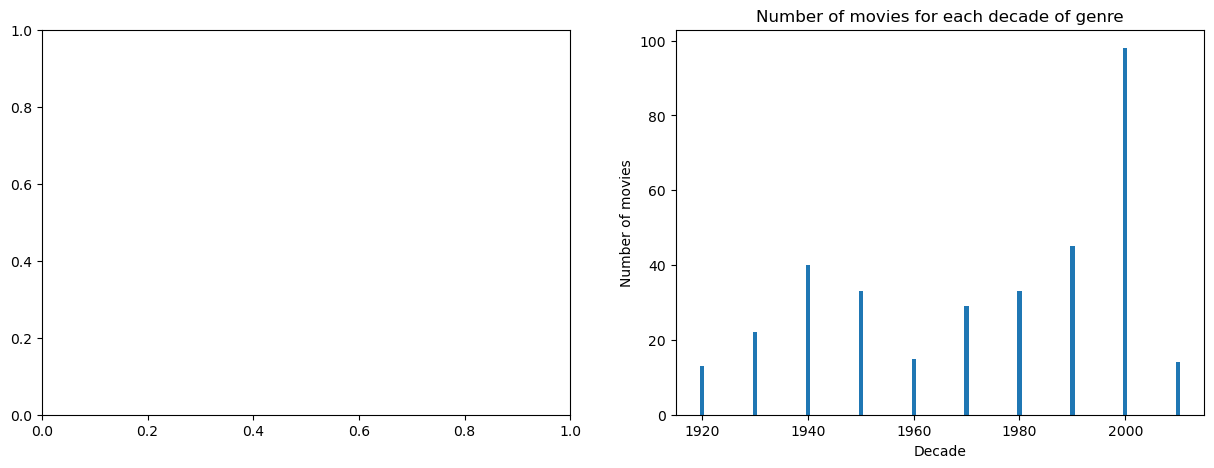

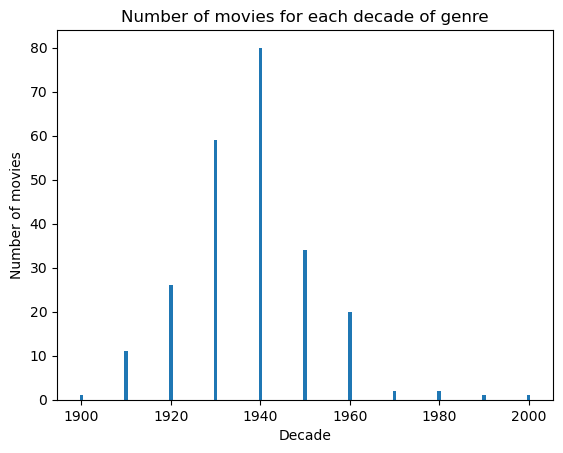

In [13]:
# use a subplot to plot plot_genre_combination_decade('Drama', 'Romance Film') and plot_genre_combination_decade('Drama', 'Black-and-white') together
fig,ax=plt.subplots(1,2,figsize=(15,5))
ax[0]=plot_genre_combination_decade('Drama', 'Romance Film')
ax[1]=plot_genre_combination_decade('Drama', 'Black-and-white')

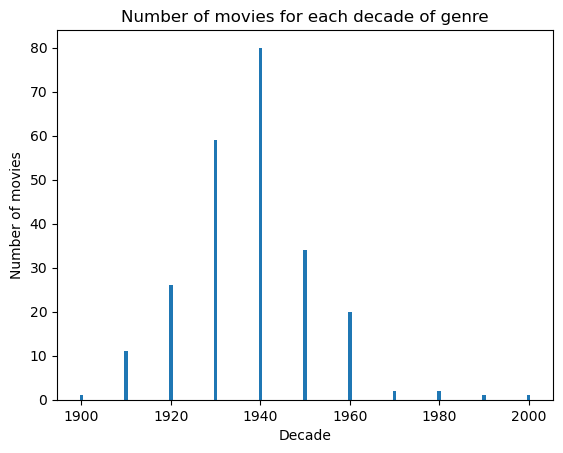

In [14]:
plot_genre_combination_decade('Drama', 'Black-and-white')

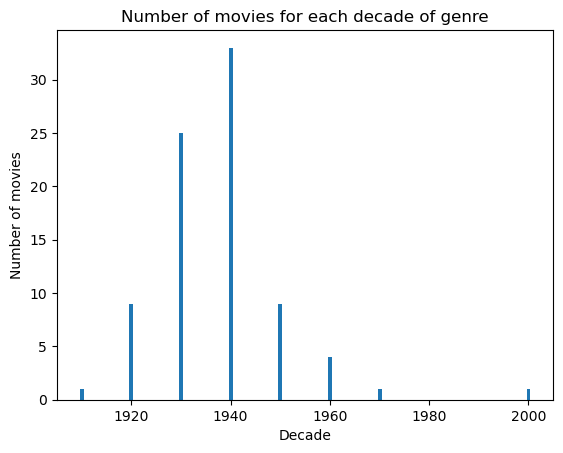

In [15]:
plot_genre_combination_decade('Romance Film', 'Black-and-white')

In [16]:
# now lets focus on the years after 2000
# create a new dataframe with only the movies after 2000
movies_2000 = movies_main[(movies_main['year_released'] >= 2000)].copy()
# do the above analysis for every year in the decade
def plot_genre_combination_year(genre1,genre2):
    # create a new dataframe with only the two genres
    movies_genre = movies_2000[movies_2000['genre'].apply(lambda x: genre1 in x and genre2 in x)].copy()
    # create a new dataframe with the number of movies for each year
    movies_genre_year = movies_genre['year_released'].value_counts().sort_index()
    # plot the number of movies for each decade
    plt.figure(figsize=(8, 4))
    plt.bar(movies_genre_year.index, movies_genre_year.values)
    plt.title("Number of movies for each year after 2000")
    plt.xlabel("Decade")
    plt.ylabel("Number of movies")
    plt.show()

# apply the function to the top 10 genres
interact(plot_genre_combination_year, genre1=genre_main.index, genre2=genre_main.index)

interactive(children=(Dropdown(description='genre1', options=('Drama', 'Comedy', 'Black-and-white', 'Romance F…

<function __main__.plot_genre_combination_year(genre1, genre2)>